In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn import preprocessing

Загрузим данные:

In [3]:
df = pd.read_csv('D:/YandexDisk/IB/ML/regression/binary.csv')

In [5]:
df.head

<bound method NDFrame.head of      admit  gre   gpa  rank
0        0  380  3.61     3
1        1  660  3.67     3
2        1  800  4.00     1
3        1  640  3.19     4
4        0  520  2.93     4
..     ...  ...   ...   ...
395      0  620  4.00     2
396      0  560  3.04     3
397      0  460  2.63     2
398      0  700  3.65     2
399      0  600  3.89     3

[400 rows x 4 columns]>

In [112]:
df.describe()

,admit,gre,gpa
count,400.000000,400.000000,400.000000
mean,0.317500,0.049064,0.049689
std,0.466087,0.009644,0.005578
min,0.000000,0.018366,0.033127
25%,0.000000,0.043412,0.045879
50%,0.000000,0.048421,0.049763
75%,1.000000,0.055099,0.053794
max,1.000000,0.066787,0.058631


In [74]:
df.dtypes

admit      int64
gre        int64
gpa      float64
rank       int64
dtype: object

Познакомимся с данными: у нас 4 переменные, 400 наблюдений. admit принимает значения 0 и 1, значение 1 имеет 31% от всех наблюдений. gre принимает значения от 220 до 800, среднее 587, стандартное отклонение 115. gpa принимает значения от 2.26 до 4, среднее 3.39, стандартное отклонение 0.38, rank - категориальная переменная, принимает значения от 1 до 4. 

In [75]:
df['rank'] = df['rank'].astype('category')

In [7]:
df['admit']

0      0
1      1
2      1
3      1
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Name: admit, Length: 400, dtype: int64

Соответственно, переменную rank переводим в фактор, а остальные нормализуем. 

In [109]:
df.gre = preprocessing.normalize([df.gre])[0]

In [110]:
df.gpa = preprocessing.normalize([df.gpa])[0]

Удостоверяемся, что нет пропущенных значений:

In [111]:
df.isna().sum()

admit    0
gre      0
gpa      0
rank     0
dtype: int64

Посмотрим распределение значений по уровням переменной admit:

In [113]:
df.groupby(['admit']).mean()

,gre,gpa
admit,,
0,0.047852,0.049011
1,0.051668,0.051144


In [114]:
df.groupby(['admit']).std()

,gre,gpa
admit,,
0,0.00967,0.005528
1,0.00909,0.005426


Как мы видим, переменные расходятся по среднему значению, но обладают приблизительно одинаковым уровнем страндартного отклонения. Группы приблизительно однородные. 

Оценим зависимость между переменными: 

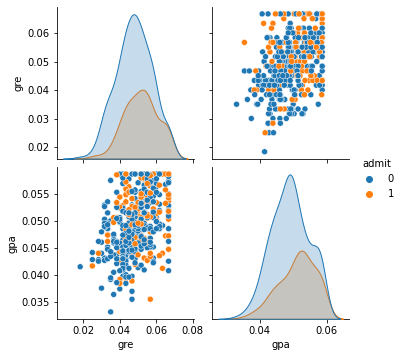

In [115]:
sns.pairplot(df, hue='admit')

Как мы видим, распределение внутри обеих переменных соотносится с тем, поступил абитуриент или нет. Чем выше оценка, тем больше вероятность поступить. При оценке корреляции между разными оценками четких кластеров "поступил/не поступил" не наблюдается. 

Оценим визуально распределение отдельных переменных:

In [12]:
gpa_distr = df['gpa'].value_counts(sort = True)


<AxesSubplot:>

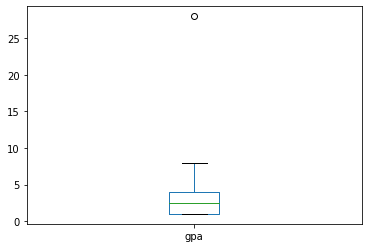

In [81]:
gpa_distr.plot(kind='box', legend=0)

<AxesSubplot:>

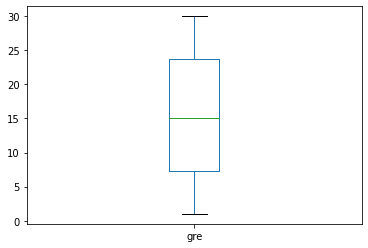

In [83]:
gre_distr = df['gre'].value_counts(sort = True)
gre_distr.plot(kind='box', legend=0)

c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='admit', ylabel='count'>

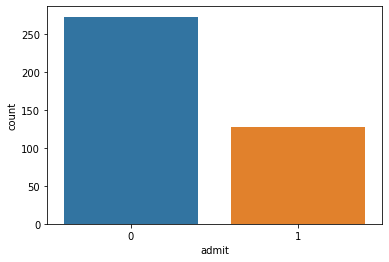

In [14]:
sns.countplot(df.admit)

Разделим переменные на обучающую и тестовую выборку. X - обучающий датафрейм, y - значения отклика. 

In [124]:
y = df.admit

In [125]:
X = df.drop(['admit'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True, random_state=42)

Проверим условия применимости модели. Мы ожидаем нормальное распределение логарифма шансов от переменных, и мульмиколлениарности. Для этого построим  IV(s)-кривые.

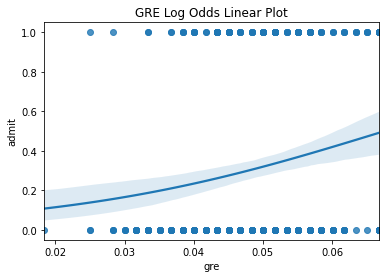

In [131]:
gre = sns.regplot(x= 'gre', y= 'admit', data= df, logistic= True).set_title("GRE Log Odds Linear Plot")

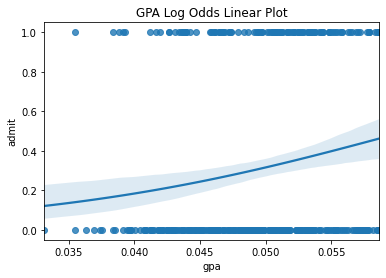

In [132]:
gpa = sns.regplot(x= 'gpa', y= 'admit', data= df, logistic= True).set_title("GPA Log Odds Linear Plot")

In [ ]:
Мы ожидали, что они будут иметь S-образную форму. Мы этого не видим отчетливо, однако они не имеют U-образной формы, что уже можно счесть добрым знаком. Сочтем, что условие выполняется. 

In [133]:
df.corr()

,admit,gre,gpa
admit,1.000000,0.184434,0.178212
gre,0.184434,1.000000,0.384266
gpa,0.178212,0.384266,1.000000


In [ ]:
Четких корреляций также не обнаружено, так что это условие тоже считаем выполненым. 

Обучим модель на полном датасете, со всеми переменными: 

In [127]:
log_regr_full = LogisticRegression(random_state=0)
log_regr_full.fit(X_train, y_train)


LogisticRegression(random_state=0)

In [128]:
y_pred_test = log_regr_full.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        90
           1       0.00      0.00      0.00        42

    accuracy                           0.68       132
   macro avg       0.34      0.50      0.41       132
weighted avg       0.46      0.68      0.55       132



c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [129]:
def get_roc_auc(estimator, y_test):
    probs = estimator.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def get_roc_auc_inv(estimator, y_test):
    probs = estimator.predict_proba(X_test)
    preds = probs[:,0]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

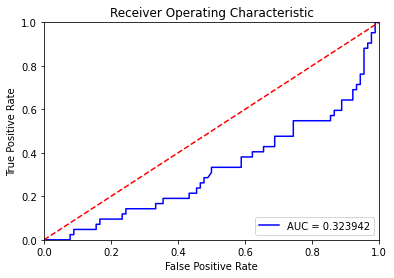

In [130]:
get_roc_auc_inv(log_regr_full, y_test)

Мы не можем назвать нашу модель хорошей. 1) AUC меньше 0,5 - следовательно, модель представляет инвертированные результаты. 2) Исходя из значения 0.32, даже после инвертирования результав у нас соотношение истиных положительных ответов модели и ложных положительных ответов модели - 68%. Это не лучший возможный результат. Это подтверждается значением precision. 
Значение recal = 1, то есть модель способна обнаруживать все классы. Оценивать модель по значению accuracy мы не можем, поскольку у нас несбаллансированные классы. 

Попробуем построить модель по отдельным переменным.
1) gre:

In [134]:
X_gre = X.drop(['gpa', 'rank'], axis=1)
X_train_gre, X_test_gre, y_train, y_test = train_test_split(X_gre, y, test_size=0.33, stratify=y, shuffle=True, random_state=42)
log_regr_gre = LogisticRegression(random_state=0)
log_regr_gre.fit(X_train_gre, y_train)
y_pred_test = log_regr_gre.predict(X_test_gre)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        90
           1       0.00      0.00      0.00        42

    accuracy                           0.68       132
   macro avg       0.34      0.50      0.41       132
weighted avg       0.46      0.68      0.55       132



c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

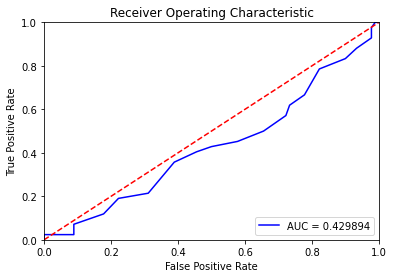

In [135]:
def get_roc_auc(estimator, y_test):
    probs = estimator.predict_proba(X_test_gre)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def get_roc_auc_inv(estimator, y_test):
    probs = estimator.predict_proba(X_test_gre)
    preds = probs[:,0]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
get_roc_auc_inv(log_regr_gre, y_test)

Модель хуже, чем по всем переменным. 
2) gpa:

In [136]:
X_gpa = X.drop(['gre', 'rank'], axis=1)
X_train_gpa, X_test_gpa, y_train, y_test = train_test_split(X_gre, y, test_size=0.33, stratify=y, shuffle=True, random_state=42)
log_regr_gpa = LogisticRegression(random_state=0)
log_regr_gpa.fit(X_train_gpa, y_train)
y_pred_test = log_regr_gpa.predict(X_test_gpa)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        90
           1       0.00      0.00      0.00        42

    accuracy                           0.68       132
   macro avg       0.34      0.50      0.41       132
weighted avg       0.46      0.68      0.55       132



c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

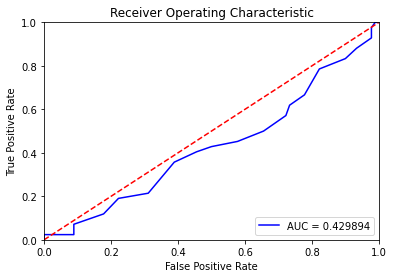

In [137]:
def get_roc_auc(estimator, y_test):
    probs = estimator.predict_proba(X_test_gpa)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def get_roc_auc_inv(estimator, y_test):
    probs = estimator.predict_proba(X_test_gpa)
    preds = probs[:,0]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
get_roc_auc_inv(log_regr_gre, y_test)

Аналогично. 
3) rank:

In [138]:
X_rank = X.drop(['gre', 'gpa'], axis=1)
X_train_rank, X_test_rank, y_train, y_test = train_test_split(X_rank, y, test_size=0.33, stratify=y, shuffle=True, random_state=42)
log_regr_rank = LogisticRegression(random_state=0)
log_regr_rank.fit(X_train_rank, y_train)
y_pred_test = log_regr_gpa.predict(X_test_rank)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55        90
           1       0.22      0.31      0.26        42

    accuracy                           0.44       132
   macro avg       0.42      0.40      0.40       132
weighted avg       0.49      0.44      0.46       132



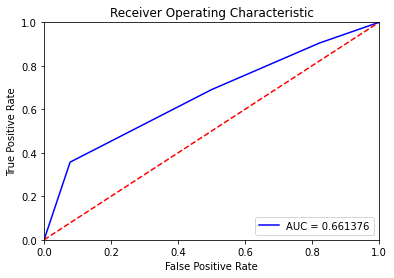

In [139]:
def get_roc_auc(estimator, y_test):
    probs = estimator.predict_proba(X_test_rank)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def get_roc_auc_inv(estimator, y_test):
    probs = estimator.predict_proba(X_test_rank)
    preds = probs[:,0]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
get_roc_auc_inv(log_regr_gre, y_test)

Эта модель лучше, чем по другим отдельным переменным, но хуже, чем по всем переменным одновременно. 

Тут бы нужно построить красивые графики распределения верных и неверных ответов, но я не успела. Поэтому тут только не очень интересные графики, как различается распределение по категориям между реальными данными и предсказанными:

c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='admit', ylabel='count'>

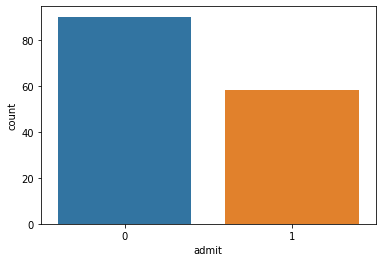

In [153]:
sns.countplot(y_test)

c:\users\dkupa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

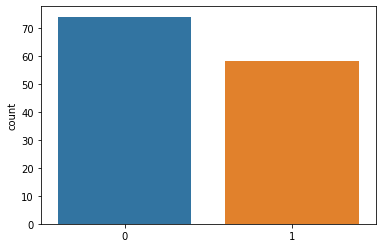

In [147]:
sns.countplot(y_pred_test)

Как мы видим, в предсказанных больше ложно-положительных результатов. Но в общем это можно было увидеть и по статистике модели. 